In [1]:
"""
为pre-A进行数据的准备：

1.选择特征；
2.把稀疏的类别型特征设为other
3.对数据进行编码
    
"""

##==================== 导入必要的工具包 ====================##
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
#from sklearn.preprocessing import OneHotEncoder
from dummyPy import OneHotEncoder
import random

import pickle  # to store temporary variable

In [2]:
##==================== 数据路径 ====================##
## 原始数据
fp_train = "sub_train.csv"
fp_test  = "sub_test.csv"

## 子数据集
fp_sub_train_f = "feature_engineering/sub_train_f.csv"

fp_col_counts = "feature_engineering/col_counts"

## 选取的特征后，重组数据 (FFM 所需要的)

fp_train_f = "feature_engineering/train_f.csv"
fp_test_f  = "feature_engineering/test_f.csv"

## 存储 label encoder 和one-hot encoding数据
fp_lb_enc = "feature_engineering/lb_enc"
fp_oh_enc = "feature_engineering/oh_enc"


In [3]:
##==================== 数据预处理 ====================##
## 所要选取的特征
'''features are used
    C1:           int,     1001, 1002, ...
    banner_pos:   int,     0,1,2,3,...
    site_domain:  object,  large set of object variables 
    site_id:      object,  large set of object variables 
    site_category:object,  large set of object variables 
    app_id:       object,  large set of object variables 
    app_category: object,  small set of object variables
    device_type:  int,     0,1,2,3,4
    device_conn_type:int,  0,1,2,3
    C14:          int,     small set of int variables
    C15:          int,     ...
    C16:          int,     ...
'''
## 建立选取特征的字典
cols = ['C1', 
        'banner_pos', 
        'site_domain', 
        'site_id',
        'site_category',
        'app_id',
        'app_category', 
        'device_type', 
        'device_conn_type',
        'C14', 
        'C15',
        'C16']

cols_train = ['id', 'click']
cols_test  = ['id']
cols_train.extend(cols)
cols_test.extend(cols)

## 读取数据，前1M 行数据
df_train_ini = pd.read_csv(fp_train, nrows = 10)
df_train_org = pd.read_csv(fp_train, chunksize = 1000000, iterator = True)
df_test_org  = pd.read_csv(fp_test,  chunksize = 1000000, iterator = True)



In [4]:
#----- 对特征进行统计——类别型 -----#
## 1.init_dict
cols_counts = {}  # 所选的每个特征数量的字典
for col in cols:
    cols_counts[col] = df_train_ini[col].value_counts()

## 2.训练集中的特征统计
for chunk in df_train_org:
    for col in cols:
        cols_counts[col] = cols_counts[col].append(chunk[col].value_counts())

## 3.测试集中的特征统计
for chunk in df_test_org:
    for col in cols:
        cols_counts[col] = cols_counts[col].append(chunk[col].value_counts())
        
## 4.把统计的每个特征的数量存入高维向量，以便于dump
for col in cols:
    cols_counts[col] = cols_counts[col].groupby(cols_counts[col].index).sum()
    # sort the counts
    cols_counts[col] = cols_counts[col].sort_values(ascending=False)   

## 5.存储统计的数量
pickle.dump(cols_counts, open(fp_col_counts, 'wb'))


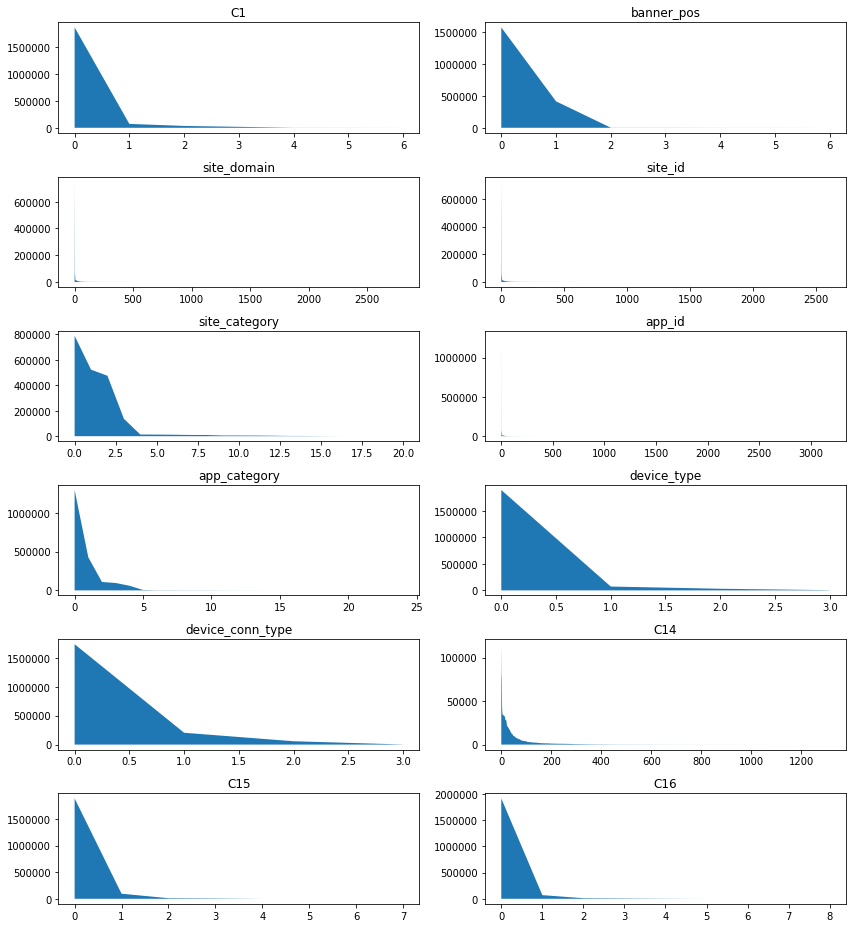

In [5]:
## 6.可视化每个特征的数量分布情况
fig = plt.figure(figsize=(12, 13))
for i, col in enumerate(cols):
    ax = fig.add_subplot(6, 2, i+1)
    ax.fill_between(np.arange(len(cols_counts[col])), cols_counts[col].get_values())
    ax.set_title(col)
    plt.tight_layout()
plt.show()

In [7]:
#----- 把稀疏特征存成'other' -----#

## 保存出现次数大于99的特征
## 把剩余的存成'other'
k = 99
col_index = {}
for col in cols:
    col_index[col] = cols_counts[col][0: k].index

df_train_org = pd.read_csv(fp_train, dtype = {'id': str}, chunksize = 1000000, iterator = True)
df_test_org  = pd.read_csv(fp_test,  dtype = {'id': str}, chunksize = 1000000, iterator = True)

## 建立新的训练集
hd_flag = True  # add column names at 1-st row
for chunk in df_train_org:
    df = chunk.copy()
    for col in cols:
        df[col] = df[col].astype('object')
        # assign all the rare variables as 'other'
        df.loc[~df[col].isin(col_index[col]), col] ='other'
    with open(fp_train_f, 'a') as f:
         df.to_csv(f, columns = cols_train, header = hd_flag, index = False)
    hd_flag = False
    
## 建立新的测试集
hd_flag = True  # add column names at 1-st row
for chunk in df_test_org:
    df = chunk.copy()
    for col in cols:
        df[col] = df[col].astype('object')
        # assign all the rare variables as 'other'
        df.loc[~df[col].isin(col_index[col]), col] = 'other'
    with open(fp_test_f, 'a') as f:
           df.to_csv(f, columns = cols_test, header = hd_flag, index = False)      
    hd_flag = False    
    

In [9]:
#----- 对特征名进行  LabelEncoder 编码 -----#
#----- 对类别型特征 one-hot 编码 -----#
'''
我们暂时不进行label/one-hot进行数据转换，在后续模型迭代的时候再做
'''
## 1. 对特征名进行编码
lb_enc = {}
for col in cols:
    col_index[col] = np.append(col_index[col], 'other') # 加上other这个特征

for col in cols:
    lb_enc[col] = LabelEncoder()
    lb_enc[col].fit(col_index[col])
    
## 存储 label encoder
pickle.dump(lb_enc, open(fp_lb_enc, 'wb'))


In [10]:
## 2.one-hot encoding

oh_enc = OneHotEncoder(cols)

df_train_f = pd.read_csv(fp_train_f, index_col=None, chunksize=1000000, iterator=True)
df_test_f  = pd.read_csv(fp_test_f, index_col=None, chunksize=1000000, iterator=True)

for chunk in df_train_f:
    oh_enc.fit(chunk)
for chunk in df_test_f:
    oh_enc.fit(chunk)
    
## 存储 one-hot encoder
pickle.dump(oh_enc, open(fp_oh_enc, 'wb'))

In [11]:
#----- 再次对新建的训练集进行压缩，通过随机提取，建立新的子训练集 -----#
n = sum(1 for line in open(fp_train_f)) - 1  
print(n)

1000000


### 最后得到训练集有1M 行数据

In [12]:
df_train = pd.read_csv(fp_train_f)
df_train.columns = cols_train

# 存储fp_train_f
df_train.to_csv(fp_sub_train_f, index=False)